In [3]:
######## make the data_loader only load images once #############
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision as tv

import numpy as np
import time
import sys
import math
from tqdm import tqdm
import random
import os, pickle, json

from nltk.tokenize import RegexpTokenizer
from transformers import BertTokenizer
from PIL import Image
from pycocotools.coco import COCO as CC
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

from catr.models import caption
from catr.models import utils as mtils
from catr.datasets import coco, utils
from catr.datasets.utils import nested_tensor_from_tensor_list
from catr.cfg_damsm_cub import Config
# from catr.configuration import Config

sys.path.append('/media/MyDataStor2/zhanghex/torch-master/MMRL/code/coco-caption')
from pycocoevalcap.eval import COCOEvalCap

In [23]:
##### dataloaders only return images, instead of image-text pairs ########
MAX_DIM = 299


def under_max(image):
    if image.mode != 'RGB':
        image = image.convert("RGB")

    shape = np.array(image.size, dtype=np.float)
    long_dim = max(shape)
    scale = MAX_DIM / long_dim

    new_shape = (shape * scale).astype(int)
    image = image.resize(new_shape)

    return image


class RandomRotation:
    def __init__(self, angles=[0, 90, 180, 270]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle, expand=True)


train_transform = tv.transforms.Compose([
    RandomRotation(),
    tv.transforms.Lambda(under_max),
    tv.transforms.ColorJitter(brightness=[0.5, 1.3], contrast=[
                              0.8, 1.5], saturation=[0.2, 1.5]),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

val_transform = tv.transforms.Compose([
    tv.transforms.Lambda(under_max),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


class CocoImage17(Dataset):
    def __init__(self, root, ann, transform=train_transform, mode='training'):
        super().__init__()

        self.root = root
        self.transform = transform
        self.annot = [val['id'] for val in ann['images']]
        if mode == 'validation':
            self.annot = self.annot
        if mode == 'training':
            self.annot = self.annot

    def _process(self, image_id):
        val = '%012d.jpg' % image_id
        return val

    def __len__(self):
        return len(self.annot)

    def __getitem__(self, idx):
        image_id = self.annot[idx]
        image = Image.open(os.path.join(self.root, self._process(image_id)))

        if self.transform:
            image = self.transform(image)
        image = nested_tensor_from_tensor_list(image.unsqueeze(0))

        return image.tensors.squeeze(0), image.mask.squeeze(0), image_id
    
    
def data_maker(config, mode='training'):
    if mode == 'training':
        train_dir = os.path.join(config.dir, 'train2017')
        train_file = os.path.join(
            config.dir, 'annotations', 'captions_train2017.json')
        with open(train_file, 'r') as f:
            trf = json.load(f)
        data = CocoImage17(train_dir, trf, transform=train_transform, mode='training')
        return data

    elif mode == 'validation':
        val_dir = os.path.join(config.dir, 'val2017')
        val_file = os.path.join(
            config.dir, 'annotations', 'captions_val2017.json')
        with open(val_file, 'r') as f:
            vlf = json.load(f)
        data = CocoImage17(val_dir, vlf, transform=val_transform, mode='validation')
        return data

    else:
        raise NotImplementedError(f"{mode} not supported")
        
        
class CocoImage14(Dataset):
    def __init__(self, root, ann, transform=train_transform, mode='training'):
        super().__init__()

        self.root = root
        self.transform = transform
        self.mode = mode
        self.annot = [val['id'] for val in ann['images']]
        if mode == 'validation':
            self.annot = self.annot
        if mode == 'training':
            self.annot = self.annot

    def _process(self, image_id):
        if self.mode == 'training':
            return 'COCO_train2014_%012d.jpg' % image_id
        elif self.mode == 'validation':
            return 'COCO_val2014_%012d.jpg' % image_id
        else:
            raise NotImplementedError('Dataloader error: Unknown mode')

    def __len__(self):
        return len(self.annot)

    def __getitem__(self, idx):
        image_id = self.annot[idx]
        image = Image.open(os.path.join(self.root, self._process(image_id)))

        if self.transform:
            image = self.transform(image)
        image = nested_tensor_from_tensor_list(image.unsqueeze(0))

        return image.tensors.squeeze(0), image.mask.squeeze(0), image_id
    
    
def data_maker14(config, mode='training'):
    if mode == 'training':
        train_dir = os.path.join(config.dir, 'images')
        train_file = os.path.join(
            config.dir, 'annotations', 'captions_train2014.json')
        with open(train_file, 'rb') as f1:
            trf = json.load(f1)
        data = CocoImage14(train_dir, trf, transform=train_transform, mode='training')
        return data

    elif mode == 'validation':
        val_dir = os.path.join(config.dir, 'images')
        val_file = os.path.join(
            config.dir, 'annotations', 'captions_val2014.json')
        with open(val_file, 'rb') as f2:
            vlf = json.load(f2)
        data = CocoImage14(val_dir, vlf, transform=val_transform, mode='validation')
        return data

    else:
        raise NotImplementedError(f"{mode} not supported")

In [4]:
## catr cub dataloader ##
from catr.cfg_damsm_cub import Config

config = Config()
dataset_train = coco.build_dataset_cub(config, mode='training')
print(f"Train: {len(dataset_train)}")
dataset_val = coco.build_dataset_cub(config, mode='validation')
print(f"Test: {len(dataset_val)}")

sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(
    sampler_train, config.batch_size, drop_last=True
)

data_loader_train = DataLoader(
    dataset_train, batch_sampler=batch_sampler_train)
data_loader_val = DataLoader(dataset_val, config.batch_size,
                             sampler=sampler_val, drop_last=False)

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated
Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Train: 88550


Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated
Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Test: 29330


In [5]:
def create_caption_and_mask(start_token, max_length, bn=1):
    caption_template = torch.zeros((bn, max_length), dtype=torch.long)
    mask_template = torch.ones((bn, max_length), dtype=torch.bool)

    caption_template[:, 0] = start_token
    mask_template[:, 0] = False

    return caption_template, mask_template

In [6]:
# used for batch prediction for speed up
@torch.no_grad()
def predict_final(model, data_loader, tokenizer):
    model.eval()
    outputs = []
    start_token = tokenizer.convert_tokens_to_ids(tokenizer._cls_token)
#     end_token = tokenizer.convert_tokens_to_ids(tokenizer._sep_token) # here for CUB captions, there's no sep token, use pad=0 instead
    end_token = 0
#     cnt = 0
    for images, masks, fn in tqdm(data_loader):
        caption, cap_mask = create_caption_and_mask(
                start_token, 128, bn=images.shape[0])
        caption = caption.to(device)
        cap_mask = cap_mask.to(device)
        imgs = mtils.NestedTensor(images, masks).to(device)
        b = torch.zeros((caption.shape[0])).bool().to(device)
        for i in range(config.max_position_embeddings - 1):
            predictions = model(imgs, caption, cap_mask)
            predictions = predictions[:, i, :]
            predicted_id = torch.argmax(predictions, axis=-1)
            end_flag = predicted_id == end_token
            b = b.logical_or(end_flag)

            if b.all(): # all the caption predictions reaches end_token, return
                break

            caption[~b, i+1] = predicted_id[~b]
            cap_mask[~b, i+1] = False
        
        results = tokenizer.batch_decode(caption.tolist(), skip_special_tokens=True)
        for i in range(len(results)):
            outputs.append({'image_id': fn[i].item(), 'caption': results[i].capitalize()})
        break
#         cnt += 1
#         if cnt == 2:
#             break

    return outputs

In [5]:
# load v3 model and checkpoint
config = Config()
device = torch.device(config.device)

## load cnn encoder ##
checkpoint_cnn = '/media/MyDataStor1/mmrl/MMRL/output/T_L1_TRX_birds_DAMSM_2020_11_09_15_02_21/Model/image_encoder600.pth'
checkpt = torch.load(checkpoint_cnn, map_location='cpu') 
image_encoder = backbone.CNN_ENCODER(nef=256, checkpoint=checkpt['model'])
image_encoder.to(device)
image_encoder.requires_grad_(False)
image_encoder.eval()

model, _ = caption.build_model(config)
model.to(device)

print("Loading Checkpoint...")
checkpoint = torch.load('catr/checkpoint_v3.pth', map_location='cpu')
model.load_state_dict(checkpoint['model'])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Loading Checkpoint...


In [8]:
# dataset_train = coco.build_dataset(config, mode='training')
dataset_val = data_maker(config, mode='validation')
# print(f"Train: {len(dataset_train)}")
print(f"Valid: {len(dataset_val)}")

# sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

# batch_sampler_train = torch.utils.data.BatchSampler(
#     sampler_train, config.batch_size, drop_last=True
# )

# data_loader_train = DataLoader(
#     dataset_train, batch_sampler=batch_sampler_train)
data_loader_val = DataLoader(dataset_val, 50, num_workers=4, 
                             sampler=sampler_val, drop_last=False)

Valid: 5000


In [9]:
# prediction full
results = predict_final(model, data_loader_val, tokenizer)

100%|██████████| 100/100 [18:59<00:00, 11.40s/it]


In [10]:
print(len(results))
for res in results[10:30]:
    print(res, sep='\n')

5000
{'image_id': 397133, 'caption': 'A group of people standing around a kitchen preparing food.'}
{'image_id': 37777, 'caption': 'A kitchen with a stove a sink and a refrigerator'}
{'image_id': 252219, 'caption': 'A group of people standing outside of a blue train.'}
{'image_id': 87038, 'caption': 'A man riding a skateboard down a flight of steps.'}
{'image_id': 174482, 'caption': 'A bike is parked on the side of the street'}
{'image_id': 403385, 'caption': 'A bathroom with a toilet, bathtub and a bathtub.'}
{'image_id': 6818, 'caption': 'A bathroom with a toilet and a sink.'}
{'image_id': 480985, 'caption': 'A motorcycle is displayed in a store window.'}
{'image_id': 458054, 'caption': 'A row of toilets sitting on top of a dirt field.'}
{'image_id': 331352, 'caption': 'A toilet with a wooden seat and a sink'}


In [11]:
# save the predicted captions to json for cocoeval
with open('catr/results/captions_val2017_v3_results.json', 'w') as ff:
    json.dump(results, ff)

## Model with damsm cnn_encoder

In [12]:
# load v3 model and checkpoint
from catr.cfg_damsm_bert import Config
config = Config()
device = torch.device(config.device)

model, _ = caption.build_model_v2(config)
model.to(device)

print("Loading Checkpoint...")
checkpoint = torch.load('catr/checkpoints/catr_damsm256_proj_coco2014_ep02.pth', map_location='cpu')
model.load_state_dict(checkpoint['model'])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/media/MyDataStor2/zhanghex/anaconda3/lib/python3.7/site-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


Loading Checkpoint...


In [31]:
# prediction full
results = predict_final(model, data_loader_val, tokenizer)

100%|██████████| 100/100 [08:12<00:00,  4.92s/it]


In [32]:
print(len(results))
for res in results[10:30]:
    print(res, sep='\n')

5000
{'image_id': 296649, 'caption': 'A group of people walking down a street.'}
{'image_id': 386912, 'caption': 'A man sitting at a desk with a laptop computer.'}
{'image_id': 502136, 'caption': 'A window with a clock on the side of it.'}
{'image_id': 491497, 'caption': 'A bedroom with a bed, a dresser and a picture on the wall.'}
{'image_id': 184791, 'caption': 'A vase with a flower in it sitting next to a vase with a flower.'}
{'image_id': 348881, 'caption': 'A large jetliner sitting on top of an airport tarmac.'}
{'image_id': 289393, 'caption': 'A brown and white cow standing next to a white fire hydrant.'}
{'image_id': 522713, 'caption': 'A bench sitting on a grassy field near a body of water.'}
{'image_id': 181666, 'caption': 'A man is leading a herd of sheep down a road.'}
{'image_id': 17627, 'caption': 'A city street with a lot of cars parked on the side of the road.'}
{'image_id': 143931, 'caption': 'A truck with a sign on the side of it'}
{'image_id': 303818, 'caption': 'A st

In [33]:
# save the predicted captions to json for cocoeval
with open('catr/results/captions_val2017_damsm_results.json', 'w') as ff:
    json.dump(results, ff)

### data visualization coco2017 val set

In [17]:
coco_val = CC('/media/MyDataStor2/zhanghex/coco2017/annotations/captions_val2017.json')
images = coco_val.dataset['images']

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


A woman sitting in front of the Eiffel tower near pigeons.
A woman sitting on ledge with three pigeons, with gate railing, trees, and base of the Eiffel Tower behind.
A man sitting on cement by some birds
a woman seated on wall and birds besides her
A woman is sitting near a prominent landmark.


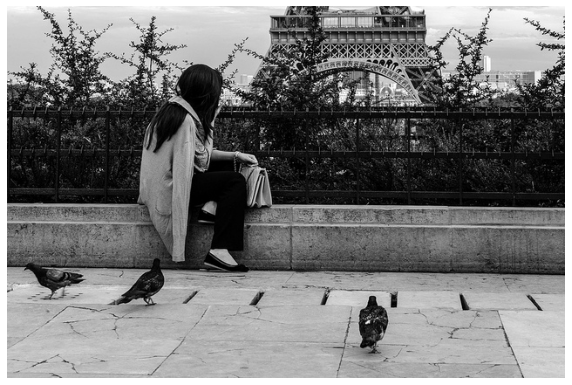

In [21]:
img_id = [456496]

annIds = coco_val.getAnnIds(imgIds=img_id)
anns = coco_val.loadAnns(annIds)
coco_val.showAnns(anns)

img =Image.open('/media/MyDataStor2/zhanghex/coco2017/val2017/%012d.jpg' % img_id[0]).convert('RGB')
plt.imshow(img)
plt.axis('off')
plt.show()

## get validation score

In [2]:
# set up file names and pathes
dataDir='/media/MyDataStor2/zhanghex/coco2017'
dataType='val2017'
algName = 'fakecap'
annFile='%s/annotations/captions_%s.json'%(dataDir,dataType)
# subtypes=['results', 'evalImgs', 'eval']
# [resFile, evalImgsFile, evalFile]= \
# ['%s/results/captions_%s_%s_%s.json'%(dataDir,dataType,algName,subtype) for subtype in subtypes]
resFile = 'catr/results/captions_val2017_damsm_results.json'

In [5]:
cocoVal = CC(annFile)
cocoRes = cocoVal.loadRes(resFile)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!


In [6]:
# create cocoEval object by taking coco and cocoRes
cocoEval = COCOEvalCap(cocoVal, cocoRes)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
# cocoEval.params['image_id'] = cocoRes.getImgIds()

# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
cocoEval.evaluate()

tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 49427, 'reflen': 48690, 'guess': [49427, 44427, 39427, 34427], 'correct': [34024, 17052, 7851, 3632]}
ratio: 1.0151365783528237
Bleu_1: 0.688
Bleu_2: 0.514
Bleu_3: 0.375
Bleu_4: 0.273
computing METEOR score...
METEOR: 0.241
computing Rouge score...
ROUGE_L: 0.514
computing CIDEr score...
CIDEr: 0.872
computing SPICE score...
SPICE: 0.169
computing WMD score...
WMD: 0.193


In [7]:
# print output evaluation scores
for metric, score in cocoEval.eval.items():
    print('%s: %.3f'%(metric, score))

Bleu_1: 0.688
Bleu_2: 0.514
Bleu_3: 0.375
Bleu_4: 0.273
METEOR: 0.241
ROUGE_L: 0.514
CIDEr: 0.872
SPICE: 0.169
WMD: 0.193


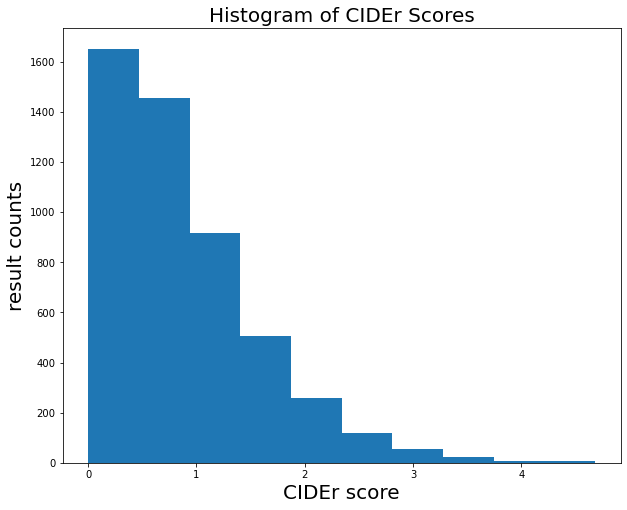

In [8]:
# plot score histogram
ciderScores = [eva['CIDEr'] for eva in cocoEval.evalImgs]
plt.hist(ciderScores)
plt.title('Histogram of CIDEr Scores', fontsize=20)
plt.xlabel('CIDEr score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.show()

In [10]:
# save the evaluation result
with open('catr/results/captions_val2017_damsm_scores.json', 'w') as f:
    json.dump(cocoEval.eval, f)

#### check the results from original catr v3 model

In [11]:
resFile = 'catr/results/captions_val2017_v3_results.json'

In [12]:
cocoVal = CC(annFile)
cocoRes = cocoVal.loadRes(resFile)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!


In [13]:
# create cocoEval object by taking coco and cocoRes
cocoEval = COCOEvalCap(cocoVal, cocoRes)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
# cocoEval.params['image_id'] = cocoRes.getImgIds()

# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
cocoEval.evaluate()

tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 49526, 'reflen': 48698, 'guess': [49526, 44526, 39526, 34526], 'correct': [36253, 19622, 9586, 4638]}
ratio: 1.0170027516530245
Bleu_1: 0.732
Bleu_2: 0.568
Bleu_3: 0.428
Bleu_4: 0.320
computing METEOR score...
METEOR: 0.267
computing Rouge score...
ROUGE_L: 0.548
computing CIDEr score...
CIDEr: 1.055
computing SPICE score...
SPICE: 0.197
computing WMD score...
WMD: 0.228


In [14]:
# print output evaluation scores
for metric, score in cocoEval.eval.items():
    print('%s: %.3f'%(metric, score))

Bleu_1: 0.732
Bleu_2: 0.568
Bleu_3: 0.428
Bleu_4: 0.320
METEOR: 0.267
ROUGE_L: 0.548
CIDEr: 1.055
SPICE: 0.197
WMD: 0.228


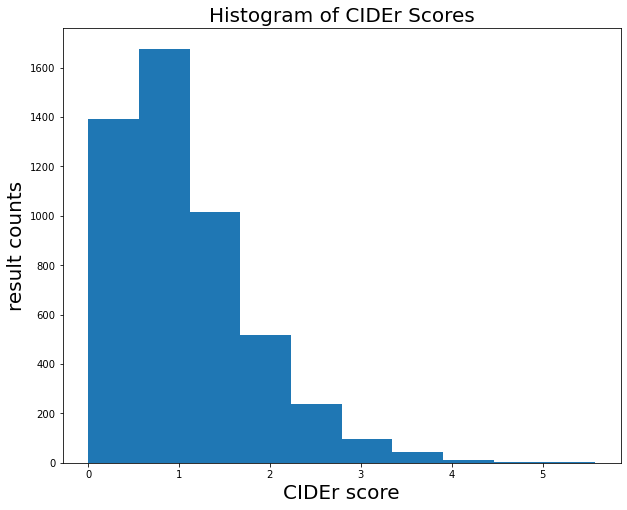

In [15]:
# plot score histogram
ciderScores = [eva['CIDEr'] for eva in cocoEval.evalImgs]
plt.hist(ciderScores)
plt.title('Histogram of CIDEr Scores', fontsize=20)
plt.xlabel('CIDEr score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.show()

In [16]:
# save the evaluation result
with open('catr/results/captions_val2017_v3_scores.json', 'w') as f:
    json.dump(cocoEval.eval, f)

## Validate on COCO2014 val set (40k)

In [27]:
# load v3 model and checkpoint
from catr.cfg_damsm_bert import Config
config = Config()
device = torch.device(config.device)

model, _ = caption.build_model_v2(config)
model.to(device)

print("Loading Checkpoint...")
checkpoint = torch.load('catr/checkpoints/catr_damsm256_proj_coco2014_ep02.pth', map_location='cpu')
model.load_state_dict(checkpoint['model'])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/media/MyDataStor2/zhanghex/anaconda3/lib/python3.7/site-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


Loading Checkpoint...


In [28]:
# dataset_train = coco.build_dataset(config, mode='training')
dataset_val = data_maker14(config, mode='validation')
# print(f"Train: {len(dataset_train)}")
print(f"Valid: {len(dataset_val)}")

# sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

# batch_sampler_train = torch.utils.data.BatchSampler(
#     sampler_train, config.batch_size, drop_last=True
# )

# data_loader_train = DataLoader(
#     dataset_train, batch_sampler=batch_sampler_train)
data_loader_val = DataLoader(dataset_val, 50, num_workers=4, 
                             sampler=sampler_val, drop_last=False)

Valid: 40504


In [34]:
# prediction full
results = predict_final(model, data_loader_val, tokenizer)

100%|██████████| 811/811 [1:06:07<00:00,  4.89s/it]


In [35]:
print(len(results))
for res in results[:10]:
    print(res, sep='\n')

40504
{'image_id': 391895, 'caption': 'A man is standing on a dirt road and a horse is standing behind him.'}
{'image_id': 522418, 'caption': 'A man is sitting in a chair in a room.'}
{'image_id': 184613, 'caption': 'A man in a hat is riding a horse.'}
{'image_id': 318219, 'caption': 'A man sitting in front of a laptop computer.'}
{'image_id': 554625, 'caption': 'A man sitting at a table with a laptop computer.'}
{'image_id': 397133, 'caption': 'A group of people sitting around a table with glasses of wine.'}
{'image_id': 574769, 'caption': 'A woman is standing in a kitchen with a baby.'}
{'image_id': 60623, 'caption': 'A woman sitting at a table with a plate of food.'}
{'image_id': 309022, 'caption': 'A kitchen with a stove, sink, and a refrigerator.'}
{'image_id': 5802, 'caption': 'A chef preparing food in a kitchen with a woman in the background.'}


In [36]:
# save the predicted captions to json for cocoeval
with open('catr/results/captions_val2014_damsm_results.json', 'w') as ff:
    json.dump(results, ff)

#### Data visualization coco 2014

In [37]:
coco_val = CC('/media/MyDataStor1/mmrl/MMRL/data/coco/annotations/captions_val2014.json')
images = coco_val.dataset['images']

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


a boy wearing headphones using one computer in a long row of computers
A little boy with earphones on listening to something.
A group of people sitting at desk using computers.
Children sitting at computer stations on a long table.
A small child wearing headphones plays on the computer.


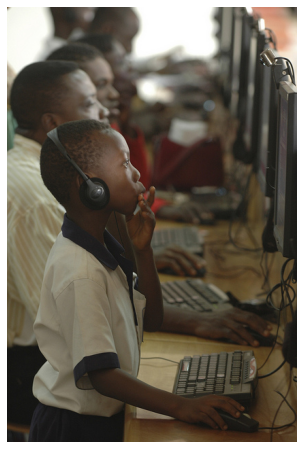

In [46]:
img_id = [554625]

annIds = coco_val.getAnnIds(imgIds=img_id)
anns = coco_val.loadAnns(annIds)
coco_val.showAnns(anns)

img =Image.open('/media/MyDataStor1/mmrl/MMRL/data/coco/images/COCO_val2014_%012d.jpg' % img_id[0]).convert('RGB')
plt.imshow(img)
plt.axis('off')
plt.show()

#### Get validation score on coco2014, damsm+catr

In [47]:
# set up file names and pathes
dataDir='/media/MyDataStor1/mmrl/MMRL/data/coco'
dataType='val2014'
annFile='%s/annotations/captions_%s.json'%(dataDir,dataType)
# subtypes=['results', 'evalImgs', 'eval']
# [resFile, evalImgsFile, evalFile]= \
# ['%s/results/captions_%s_%s_%s.json'%(dataDir,dataType,algName,subtype) for subtype in subtypes]
resFile = 'catr/results/captions_val2014_damsm_results.json'

In [48]:
cocoVal = CC(annFile)
cocoRes = cocoVal.loadRes(resFile)

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!


In [49]:
# create cocoEval object by taking coco and cocoRes
cocoEval = COCOEvalCap(cocoVal, cocoRes)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
# cocoEval.params['image_id'] = cocoRes.getImgIds()

# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
cocoEval.evaluate()

tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 399841, 'reflen': 393927, 'guess': [399841, 359337, 318833, 278329], 'correct': [276048, 138678, 63372, 29271]}
ratio: 1.0150129338684553
Bleu_1: 0.690
Bleu_2: 0.516
Bleu_3: 0.376
Bleu_4: 0.273
computing METEOR score...
METEOR: 0.241
computing Rouge score...
ROUGE_L: 0.515
computing CIDEr score...
CIDEr: 0.861
computing SPICE score...
SPICE: 0.169
computing WMD score...
WMD: 0.195


In [50]:
# print output evaluation scores
for metric, score in cocoEval.eval.items():
    print('%s: %.3f'%(metric, score))

Bleu_1: 0.690
Bleu_2: 0.516
Bleu_3: 0.376
Bleu_4: 0.273
METEOR: 0.241
ROUGE_L: 0.515
CIDEr: 0.861
SPICE: 0.169
WMD: 0.195


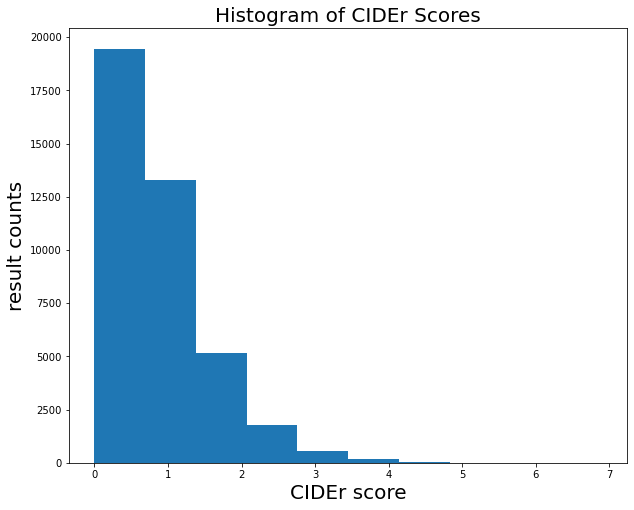

In [51]:
# plot score histogram
ciderScores = [eva['CIDEr'] for eva in cocoEval.evalImgs]
plt.hist(ciderScores)
plt.title('Histogram of CIDEr Scores', fontsize=20)
plt.xlabel('CIDEr score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.show()

In [52]:
# save the evaluation result
with open('catr/results/captions_val2014_damsm_scores.json', 'w') as f:
    json.dump(cocoEval.eval, f)

## Check and compare all the results

In [25]:
with open('catr/results/captions_val2017_v3_results.json', 'r') as f:
    resv3 = json.load(f)

In [27]:
print(len(resv3))
for res in resv3[10:30]:
    print(res, sep='\n')

5000
{'image_id': 296649, 'caption': 'A group of people riding motorcycles down a street.'}
{'image_id': 386912, 'caption': 'A woman sitting at a desk with a laptop.'}
{'image_id': 502136, 'caption': 'A run down building with a broken door.'}
{'image_id': 491497, 'caption': 'A bed sitting in a bedroom next to a book shelf.'}
{'image_id': 184791, 'caption': 'A picture of a vase and a vase with a candle.'}
{'image_id': 348881, 'caption': 'A plane is being loaded with cargo on the tarmac.'}
{'image_id': 289393, 'caption': 'A couple of chickens standing next to each other.'}
{'image_id': 522713, 'caption': 'A bench sitting on top of a lush green field.'}
{'image_id': 181666, 'caption': 'A man is herding a herd of sheep in a field.'}
{'image_id': 17627, 'caption': 'A city street with cars and a car on it'}
{'image_id': 143931, 'caption': 'A bus parked in front of a building.'}
{'image_id': 303818, 'caption': 'A group of people walking across a street.'}
{'image_id': 463730, 'caption': 'A ma

In [17]:
with open('catr/results/captions_val2017_v3_scores.json', 'r') as f:
    resv3 = json.load(f)
with open('catr/results/captions_val2017_damsm_scores.json', 'r') as f:
    resdm = json.load(f)

In [19]:
print('Matrix    V3    DAMSM\n')
for k in resv3.keys():
    print('%s:    %.5f    %.5f\n' % (k, resv3[k], resdm[k]))

Matrix    V3    DAMSM

Bleu_1:    0.73200    0.68837

Bleu_2:    0.56796    0.51401

Bleu_3:    0.42769    0.37471

Bleu_4:    0.32018    0.27295

METEOR:    0.26679    0.24080

ROUGE_L:    0.54803    0.51424

CIDEr:    1.05539    0.87205

SPICE:    0.19714    0.16907

WMD:    0.22760    0.19299

